In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-nearest-earth-objects/neo_v2.csv
/kaggle/input/nasa-nearest-earth-objects/neo.csv


In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor

In [3]:
df = pd.read_csv('/kaggle/input/nasa-nearest-earth-objects/neo.csv')

In [4]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [6]:
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [7]:
# no nulls 
df.isnull().sum() 

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [8]:
def analyze_duplicates_and_uniques_as_table(dataframe_name):
    # Initialize two empty lists to store the count of unique and duplicated values for each column
    unique_values = []
    duplicated_values = []

    # Loop through each column in the DataFrame
    for column in dataframe_name.columns:
        # Append the count of unique values in the column to the unique_values list
        unique_values.append(dataframe_name[column].nunique())
        # Append the count of duplicated values in the column to the duplicated_values list
        duplicated_values.append(dataframe_name[column].duplicated().sum())

    # Create a new DataFrame to display the results
    # It includes the column names, count of unique values, and count of duplicated values
    results_df = pd.DataFrame({
        'Column': dataframe_name.columns,
        'Unique Values': unique_values,
        'Duplicated Values': duplicated_values
    })

    # Return the results DataFrame
    return results_df


result_table = analyze_duplicates_and_uniques_as_table(df)
# Prints the resulting DataFrame which shows the unique and duplicated values count for each column in df
print(result_table)


               Column  Unique Values  Duplicated Values
0                  id          27423              63413
1                name          27423              63413
2    est_diameter_min           1638              89198
3    est_diameter_max           1638              89198
4   relative_velocity          90828                  8
5       miss_distance          90536                300
6       orbiting_body              1              90835
7       sentry_object              1              90835
8  absolute_magnitude           1638              89198
9           hazardous              2              90834


In [9]:
df.drop(columns=['id','name','orbiting_body','sentry_object'],axis=1,inplace=True)
df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


**EDA**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Hazardous VS Diamtere')

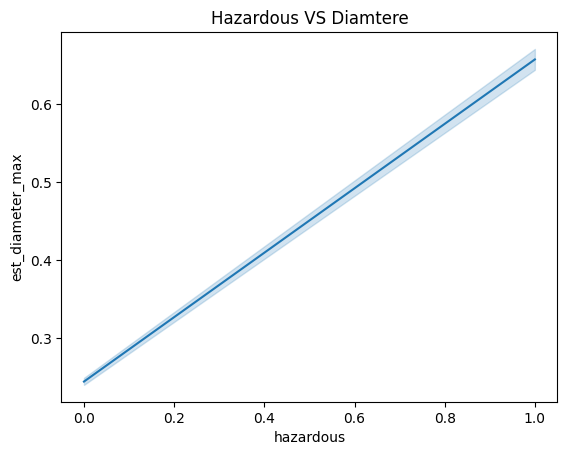

In [10]:
sns.lineplot(x=df.hazardous,y=df.est_diameter_max)
plt.title('Hazardous VS Diamtere')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Hazardous VS Relative Velocity')

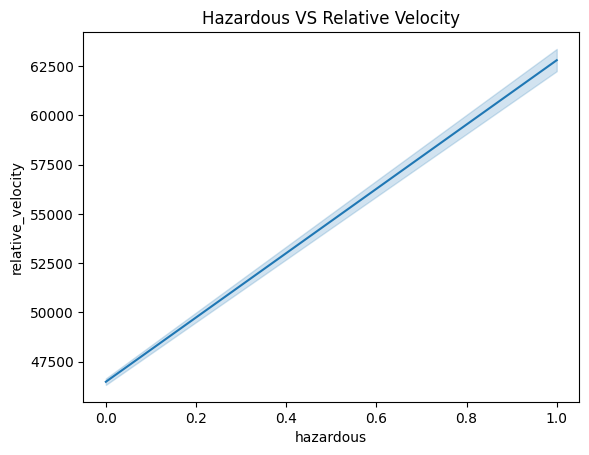

In [11]:
sns.lineplot(x=df.hazardous,y=df.relative_velocity)
plt.title('Hazardous VS Relative Velocity')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Hazardous VS Absolute Magnitude')

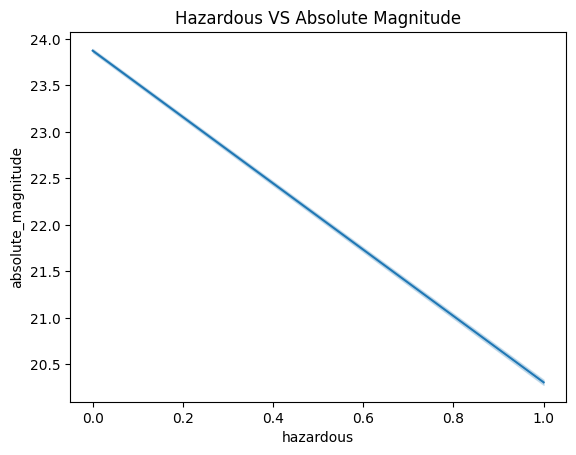

In [12]:
sns.lineplot(x=df.hazardous,y=df.absolute_magnitude)
plt.title('Hazardous VS Absolute Magnitude')

<Axes: xlabel='hazardous'>

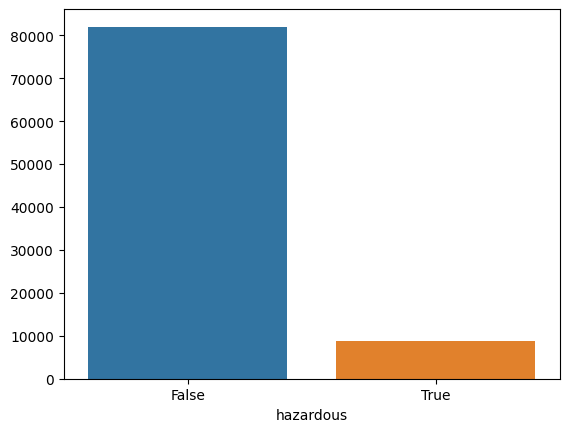

In [13]:
hazar_count=df.hazardous.value_counts()
sns.barplot(x=hazar_count.index,y=hazar_count.values)

In [14]:
df['hazardous']=df['hazardous'].replace({'False':0,'True':1}).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   est_diameter_min    90836 non-null  float64
 1   est_diameter_max    90836 non-null  float64
 2   relative_velocity   90836 non-null  float64
 3   miss_distance       90836 non-null  float64
 4   absolute_magnitude  90836 non-null  float64
 5   hazardous           90836 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 4.2 MB


In [15]:
X=df.drop(columns='hazardous')
y=df.hazardous.values

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(72668, 5)
(18168, 5)
(72668,)
(18168,)


In [17]:
models={
    'DT':DecisionTreeClassifier(),
    'RF':RandomForestClassifier(),
    'XGB':XGBClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

In [18]:
for name,model in models.items():
    model.fit(X_train,y_train)
    y_pred=model.predict_proba(X_test)[:, 1]
    AUC=roc_auc_score(y_test,y_pred)
    print(f'the AUC for {name} is {AUC}')

the AUC for DT is 0.7078744522355832
the AUC for RF is 0.9349399435971484
the AUC for XGB is 0.9224299301506584
the AUC for KNeighbors is 0.578893063867819
the AUC for AdaBoost is 0.9109793040721096


In [19]:

for model_name, model in models.items():
    if model_name == 'DT':
        scores_DT=[]
        max_depth=[2,5,10,20,30,40,50,100]
        for d in max_depth:
            DT=DecisionTreeClassifier(max_depth=d)
            DT.fit(X_train,y_train)
            y_pred=DT.predict_proba(X_test)[:,1]
            AUC_DT=roc_auc_score(y_test,y_pred)
            scores_DT.append((d,AUC_DT))
    
    elif model_name == 'RF':
        scores_RF=[]
        max_depth=[2,5,10,20,30,40,50,100,250,500]
        for d in max_depth:
            RF=RandomForestClassifier(max_depth=d)
            RF.fit(X_train,y_train)
            y_pred=RF.predict_proba(X_test)[:,1]
            AUC=roc_auc_score(y_test,y_pred)
            scores_RF.append((d,AUC))
            
    elif model_name == 'XGB':
        scores_XGB=[]
        max_depth=[2,5,10,20,30,40,50,100]
        for d in max_depth:
            XGB=XGBClassifier(max_depth=d)
            XGB.fit(X_train,y_train)
            y_pred=XGB.predict_proba(X_test)[:,1]
            AUC_XGB=roc_auc_score(y_test,y_pred)
            scores_XGB.append((d,AUC_XGB))
            
    elif model_name == 'KNeighbors':
        scores_KN=[]
        n_neighbors=[2,5,10,20,30,40,50,100]
        for d in n_neighbors:
            KN=KNeighborsClassifier(n_neighbors=d)
            KN.fit(X_train,y_train)
            y_pred=KN.predict_proba(X_test)[:,1]
            AUC_KN=roc_auc_score(y_test,y_pred)
            scores_KN.append((d,AUC_KN))
            
    elif model_name == 'AdaBoost':
        scores_ADA=[]
        n_estimators=[100,500,1000,2000]
        for d in n_estimators:
            ADA=AdaBoostClassifier(n_estimators=d)
            ADA.fit(X_train,y_train)
            y_pred=ADA.predict_proba(X_test)[:,1]
            AUC_ADA=roc_auc_score(y_test,y_pred)
            scores_ADA.append((d,AUC_ADA))
            

In [20]:
df_score_DT=pd.DataFrame(scores_DT,columns=['max_depth','AUC_Decision_Tree'])
df_score_RF=pd.DataFrame(scores_RF,columns=['max_depth','AUC_Random_Forest'])
df_score_XGB=pd.DataFrame(scores_XGB,columns=['max_depth','AUC_XGB_Classifier'])
df_score_KN=pd.DataFrame(scores_KN,columns=['n_neighbors','AUC_KNeighbors'])
df_score_ADA=pd.DataFrame(scores_ADA,columns=['n_estimators','AUC_AdaBoost'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='max_depth', ylabel='AUC_Decision_Tree'>

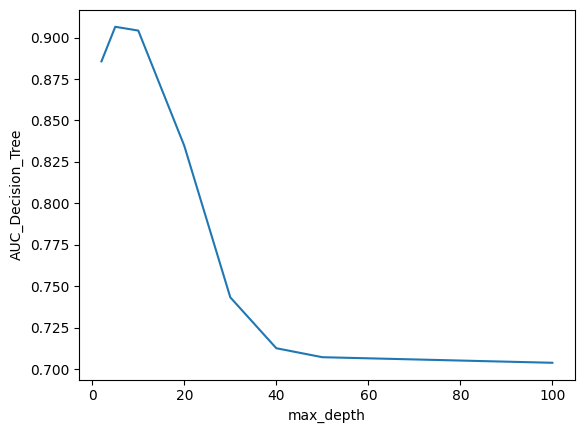

In [21]:
sns.lineplot(x=df_score_DT.max_depth,y=df_score_DT.AUC_Decision_Tree)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='max_depth', ylabel='AUC_Random_Forest'>

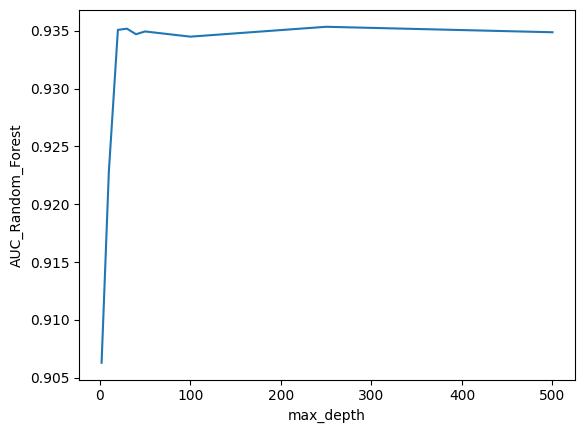

In [22]:
sns.lineplot(x=df_score_RF.max_depth,y=df_score_RF.AUC_Random_Forest)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='max_depth', ylabel='AUC_XGB_Classifier'>

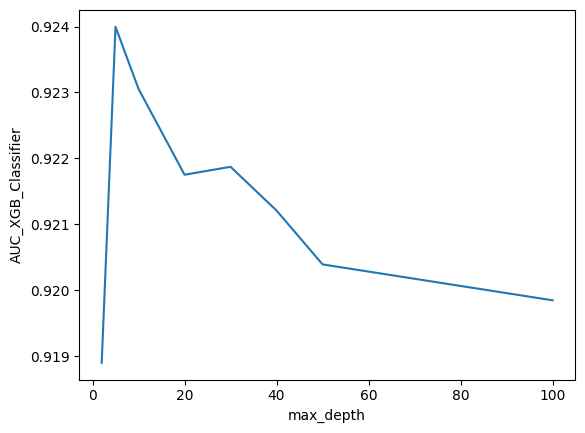

In [23]:
sns.lineplot(x=df_score_XGB.max_depth,y=df_score_XGB.AUC_XGB_Classifier)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='n_neighbors', ylabel='AUC_KNeighbors'>

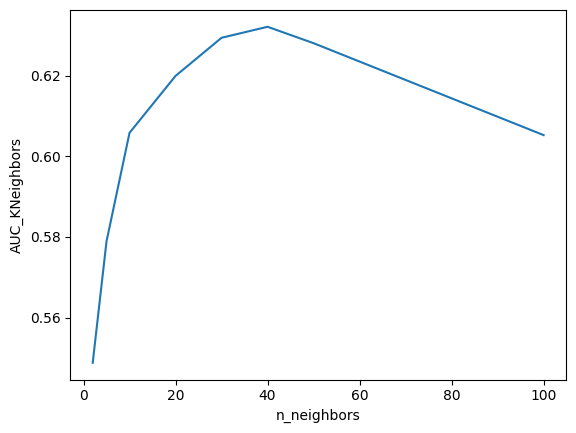

In [24]:
sns.lineplot(x=df_score_KN.n_neighbors,y=df_score_KN.AUC_KNeighbors)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='n_estimators', ylabel='AUC_AdaBoost'>

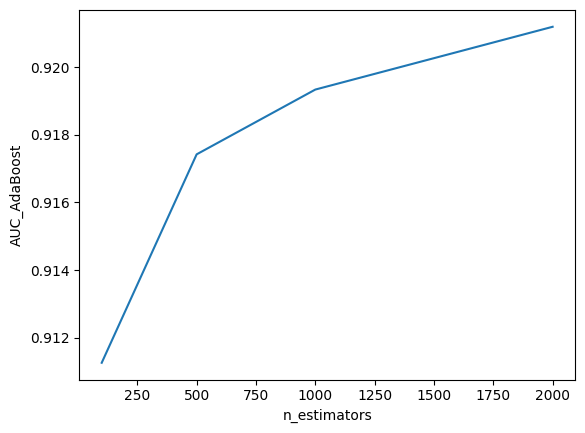

In [25]:
sns.lineplot(x=df_score_ADA.n_estimators,y=df_score_ADA.AUC_AdaBoost)

In [26]:
df_score_DT

,max_depth,AUC_Decision_Tree
0,2,0.885622
1,5,0.906489
2,10,0.904200
3,20,0.834696
4,30,0.743302
5,40,0.712600
6,50,0.707189
7,100,0.703825


In [27]:
df_score_RF

,max_depth,AUC_Random_Forest
0,2,0.906288
1,5,0.912424
2,10,0.922782
3,20,0.935070
4,30,0.935175
5,40,0.934694
6,50,0.934935
7,100,0.934485
8,250,0.935339
9,500,0.934865


In [28]:
df_score_XGB

,max_depth,AUC_XGB_Classifier
0,2,0.918900
1,5,0.923996
2,10,0.923054
3,20,0.921752
4,30,0.921872
5,40,0.921209
6,50,0.920392
7,100,0.919847


In [29]:
df_score_KN

,n_neighbors,AUC_KNeighbors
0,2,0.548780
1,5,0.578893
2,10,0.605801
3,20,0.619919
4,30,0.629376
5,40,0.632104
6,50,0.628037
7,100,0.605240


In [30]:
df_score_ADA

,n_estimators,AUC_AdaBoost
0,100,0.911266
1,500,0.917422
2,1000,0.919335
3,2000,0.921190


In [31]:
RF=RandomForestClassifier(max_depth=40)
RF.fit(X_train,y_train)
y_pred_final=RF.predict_proba(X_test)[:,1]
AUC_final=roc_auc_score(y_test,y_pred_final)
print(AUC_final)

0.9353114029253248


In [32]:
FBR,TPR,threshould=roc_curve(y_test,y_pred_final)

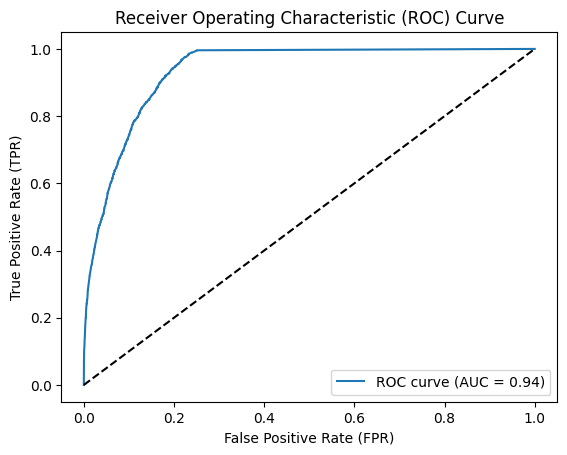

In [33]:
plt.plot(FBR, TPR, label='ROC curve (AUC = {:.2f})'.format(AUC_final))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random prediction
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [34]:
valid_scores=cross_val_score(RF,X,y,cv=8,scoring='roc_auc')

In [35]:
for i in range(8):
     print(f'valid_scores for cv {i+1} is {valid_scores[i]}')

valid_scores for cv 1 is 0.9149379097229887
valid_scores for cv 2 is 0.922649244012802
valid_scores for cv 3 is 0.9261257256373469
valid_scores for cv 4 is 0.9320304602141045
valid_scores for cv 5 is 0.9397462902240987
valid_scores for cv 6 is 0.9355643128631025
valid_scores for cv 7 is 0.9373842895609725
valid_scores for cv 8 is 0.952818838081102


In [36]:
print(f'the average validation score for predicting Hazardous objects around the globe is {valid_scores.mean()}')

the average validation score for predicting Hazardous objects around the globe is 0.9326571337895647
